In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
local_df = pd.read_csv('local.csv')
local_df['server'] = 'localhost'

remote_df = pd.read_csv('remote.csv')
remote_df['server'] = 'lab.ms.mff.cuni.cz'

# Assignment 1 - Java RMI

Raw data from `./run-measurements localhost` are in `local_df` and `./run-measurements u-pl*.ms.mff.cuni.cz` are in `remote_df`.
The measurements are done on 100 nodes and egdes start at 200 go up till 500 by steps of 50.
Graph density is one comparison criteria.

Other comparison criteria is found distance of randomly generated nodes on given graph.
Following table show what distances there are in the data and how may observations with given distance there are.
It is important to consider these since it is not uniformly distributed which is expected but does affect the graphs so keep it in mind.

In [3]:
display(local_df.groupby('distance').size())

distance
-1    144
 0     20
 1     60
 2    108
 3    264
 4    256
 5    184
 6     48
 7     24
 8     12
dtype: int64

## Data preparation

Process data from `local_df` and `remote_df` into a single dataframe `df` that has each measurement for given option separately, add density and parse which samples have local/remote searcher, local/remote node locations, and use transitive algorithm.

In [4]:
df = local_df.append(remote_df)
df = df.apply(pd.to_numeric, errors='ignore')
df['density'] = 2 * df['edges'] / (df['nodes'] * (df['nodes'] - 1))

df = df.melt(
    id_vars=['server', 'distance', 'density', 'n'],
    value_vars=['local_searcher-local_nodes', 'local_searcher-remote_nodes', 'remote_searcher-local_nodes', 'remote_searcher-remote_nodes',
                'local_searcher-local_nodes-transitive', 'local_searcher-remote_nodes-transitive', 'remote_searcher-local_nodes-transitive', 'remote_searcher-remote_nodes-transitive'],
    var_name="option", value_name="time"
)

locality_values = [
    'local',
    'remote',
]

searcher_conditions = [
    (df['option'].str.contains('local_searcher')),    
    (df['option'].str.contains('remote_searcher')),
]
df['searcher'] = np.select(searcher_conditions, locality_values)

nodes_conditions = [
    (df['option'].str.contains('local_nodes')),    
    (df['option'].str.contains('remote_nodes')),
]
df['node_location'] = np.select(nodes_conditions, locality_values)

transitivity_values = [
    False,
    True,
]
transitivity_conditions = [
    (df['option'].str.contains('transitive') == False),    
    (df['option'].str.contains('transitive') == True),
]
df['transitivity'] = np.select(transitivity_conditions, transitivity_values)

### Now follows the dataframe that we use and not modify any further. (for reference)

In [22]:
print("HEAD")
print(df.head())

print("\nINFO")
print(df.info())

HEAD
      server  distance   density   n                      option  time  \
0  localhost         5  0.040404   4  local_searcher-local_nodes   591   
1  localhost         5  0.040404   8  local_searcher-local_nodes   591   
2  localhost         5  0.040404  12  local_searcher-local_nodes   591   
3  localhost         5  0.040404  16  local_searcher-local_nodes   591   
4  localhost         2  0.040404   4  local_searcher-local_nodes    35   

  searcher node_location  transitivity  
0    local         local             0  
1    local         local             0  
2    local         local             0  
3    local         local             0  
4    local         local             0  

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17920 entries, 0 to 17919
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   server         17920 non-null  object 
 1   distance       17920 non-null  int64  
 2   density  

## Task 1 - Local searcher + Local nodes

Bellow graphs compares local searcher + local nodes against other options discussed further.
Since this solution does not contain any RMI methods whatsoever it is the fastest baseline others compare against.

## Task 2 - Remote searcher + Local nodes

Again below graphs compares remote searcher + local nodes against other options.

__Question__ : How does the server `Searcher` object access the `Node` objects and the set of their neighbors?

__Answer__:

Client has a proxy of `Searcher` object which is on the server, client calls
``` java
remoteSearcher.getDistance(localNodes[idxFrom], localNodes[idxTo]);
```
and with that passed sever 2 serialized `Node` objects stored on the client.
However, to serialize this object we have to serialize its contents which is a sets of other neighboring nodes, to serialize that we get set of its neighbors etc.
Server upon receiving these objects does starts the `getDistance` method on the searcher which uses `Node.getNeighbors` this call does return serialized set present on the copy of serialized node set.
Basically server receives the whole connected component in this call to `getDistance` because of serialization of its arguments.

## Task 3 - Local searcher + Remote nodes

Again below graphs compare use of remote searcher + remote nodes agains other options.

__Question__: How does the local `Searcher` object access the server Node objects? What exactly does the `NodeFactory` return to the client from `createNode`?

__Answer__:

First, I will answer the later part of the question, `NodeFactory` returns a proxy to a `Node` object stored on the server.
Client puts this proxy into an array of `Node` proxies that it later passes to local `Searcher` object.

This seacher object does the same call as described previously (but with local searcher + remote nodes) and thus calls `getDistance` on proxy node.
This proxy node calls `getDistance` on server and returns corresponding serialized set of node proxies back to client.


## Task 4 - Remote seacher + Remote nodes

__Question__: How does the server `Searcher` access the server `Node` objects (on the same server)?

__Answer__:

Server searcher should be able to identify that the proxies to nodes passed to it in the call to `getDistance` are in fact proxies to object on the server by the uniques identifier assigned to exported objects.
The question is how does client serialize proxy objects.
I think that it has to do serialize the information on the proxy nodes so that the remote object can do the RPC on those serialized proxies which would in fact be local RPC.
I did not confirm this with packet captures and was not able to find it on the net, but the plots suggest that there is more to it than just simple "server-local" computation of search.

## Plot comparing different searcher/nodes location w.r.t. graph density with localhost server (Tasks 1,2,3,4)

Plot show comparison of different searcher/nodes location represented by 4 colors, with density (`2 * |E| / (|V| * (|V| - 1))` where `|V| = 100`) on the x axis  and time in microseconds on the _logarithmic_ y axis.
This setting of axis is simmilar in the rest of the document for density vs. time plots if not stated otherwise.

I have chosen boxplot since there was 40 distance measurements per given graph (i.e. also graph density).
Now follows a comments for each option:

1. _Local searcher + Local nodes_ (blue)

This serves as a baseline - fastest solution, RMI not included.

2. _Remote searcher + Local nodes_ (green)

As stated in answer in Task 2 section, client has to serialize and pass the whole relevant graph to the server, that explains roughly constant time.
It is probable that higher density graphs need to send bigger connected components to server but since this is log scale and we are measuring on just 100 nodes it is not seen here.

> The reason we are measuring on 100 nodes is that the computations took pretty long time with higher node counts since we had to run them multiple times.

3. _Local searcher + Remote nodes_ (yellow)

As stated in answer in Task 3 local searcher asks server for remote proxies level by level (meaning level of neighborhood).
This means that there is a significant traffic between client and the server.
This option has also significant outliers and those will be explained in the next graph, that is due to differences on how long it takes to find a path of specific length.

4. _Remote searcher + Remote nodes_ (red)

This options is among the worst together with number 3.
And that may suggest my assumptions about question in task 4.


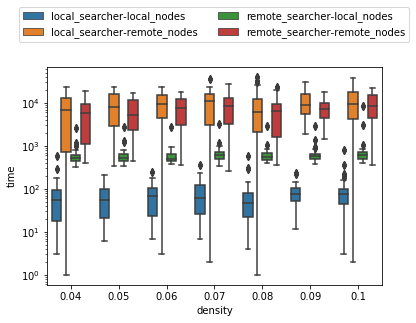

In [6]:
g = sns.boxplot(
    data=df[(df['server'] == 'localhost') & (df['transitivity'] == False)],
    x='density', y='time', hue='option')
g.set_yscale('log')
g.set_xticklabels(df['density'].unique().round(2))
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)



## Plot comparing different searcher/nodes location w.r.t. node distance with localhost server (Tasks 1,2,3,4)

Plot show comparison of different searcher/nodes location represented by 4 colors, with node distance the x axis (-1 means not reached) and time in microseconds on the _logarithmic_ y axis.
This setting of axis is simmilar in the rest of the document for distance vs. time plots if not stated otherwise.

I have chosen boxplot since there was 40 distance measurements per given graph, however the number of samples in each boxplot is not the same refer to the table at the beginning.
This means that the outliers near low distances (0, 1) and high distances (7, 8) have to be carefully compared to mid range distances. 

Now follows a comments for each option:

1. _Local searcher + Local nodes_ (blue)

This serves as a baseline - fastest solution, RMI not included.
Similar to most of the other options not finding a node may take arbitrary long time, it is longer in denser graphs since we have to search the whole connected component of given node and hope to find destination node.

Furthermore, the longer the path is the more nodes we have to traverse i.e. the more time it takes.

2. _Remote searcher + Local nodes_ (green)

Same pattern as before, same reasoning.
Notice that the time cost is not rising with the length of the path increasing, that is due to the log scale (server has to search the copy of the graph similarly to local searcher, however the transfer itself takes time).
This solution introduces almost no outliers.

3. _Local searcher + Remote nodes_ (yellow)
4. _Remote searcher + Remote nodes_ (red)

Same pattern with 3 and 4 sticking together, the longer the path the longer time.
I am not sure what caused the anomaly on distance 0 where local searcher + remote nodes was faster that fully local solution.


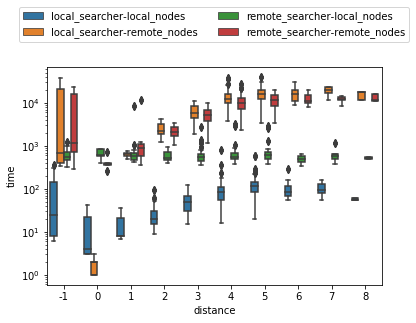

In [7]:
g = sns.boxplot(
    data=df[(df['server'] == 'localhost') & (df['transitivity'] == False)],
    x='distance', y='time', hue='option')
g.set_yscale('log')
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)

## Task 5 - Introduce network latency (part 1 - distance)

Next facet plot shows impact of network when the server is on computer in lab.
This time we start with distance graph and again have log scale of time.

When it comes to network latency it is important to mention that I have meassured this on windows using WSL2 which is known to have issues with localhost delays.

1. _Local searcher + Local nodes_ (top left)

Again baseline for comparison, no latency introduced.

2. _Remote searcher + Local nodes_ (top right)

Same pattern as before, same reasoning.
This time the latency simply moved the time an order of magnitude up.

3. _Local searcher + Remote nodes_ (bottom left)

Worst network solution over all (cca order of magnitude compared to no. 2).
Localhost is similar to localhost and lab version of no. 4.
However, to find a distance to a node itself it the fastest as seen before.
This means that there is no need to contact the server and the proxy itself suffices to determine reference equality.

4. _Remote searcher + Remote nodes_ (bottom right)

This is the key graph for remote nodes and searcher combination.
It shows that there is no excessive communication between clien and server since that would increase the time similarly to solution no. 3.
The trend of blue boxes is may be similar to yellow boxes but the log scale prevents to see that clearly.
Still it should confirm that the server does it's computation with it's nodes directly and then sends client the result.


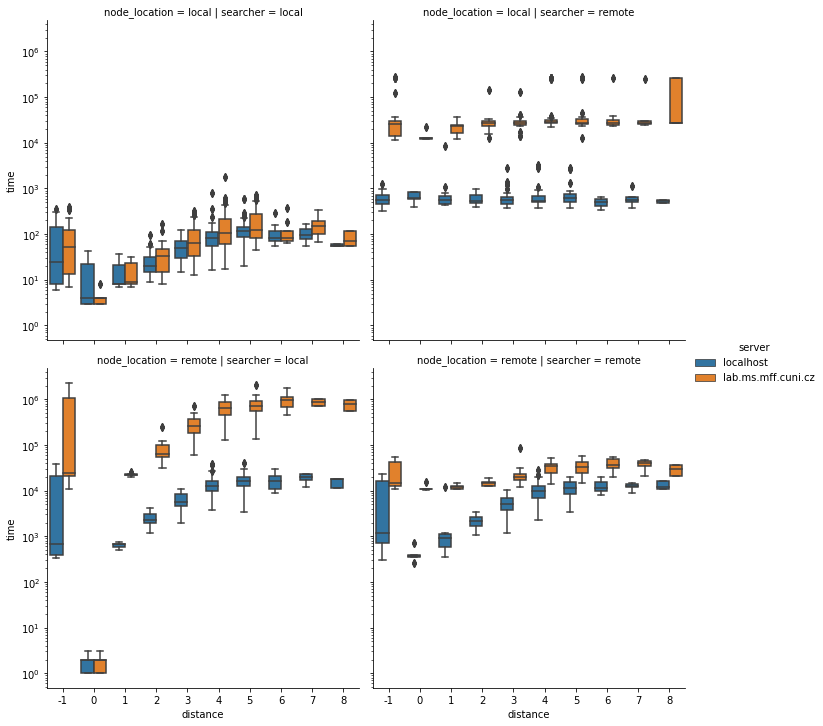

In [8]:
g = sns.catplot(
    data=df[df['transitivity'] == False],
    x='distance', y='time', hue='server', row='node_location', col='searcher', kind='box')
g.set(yscale='log')

## Task 5 - Introduce network latency (part 2 - density)

Similary to previous plot now we show the impact of network latency based on graph density.

1. _Local searcher + Local nodes_ (top left)

Again baseline for comparison, no latency introduced.

2. _Remote searcher + Local nodes_ (top right)

Same pattern as before, same reasoning.
This time the latency simply moved the time an order of magnitude up.
Outliers are caused by differences in distance e.g. it takes long time to find that there is no path.
That is a general observation in these density graphs and it fully manifests in the following option.

3. _Local searcher + Remote nodes_ (bottom left)

Worst network solution over all again with huge outliers that is because of reasons mentioned previously i.e. we do not use huge graphs + log scale + different distances have drastically different time.
Localhost is again similar to localhost version of no. 4.

4. _Remote searcher + Remote nodes_ (bottom right)

This part of the plot again that the network latency is not excessive as in no. 3.

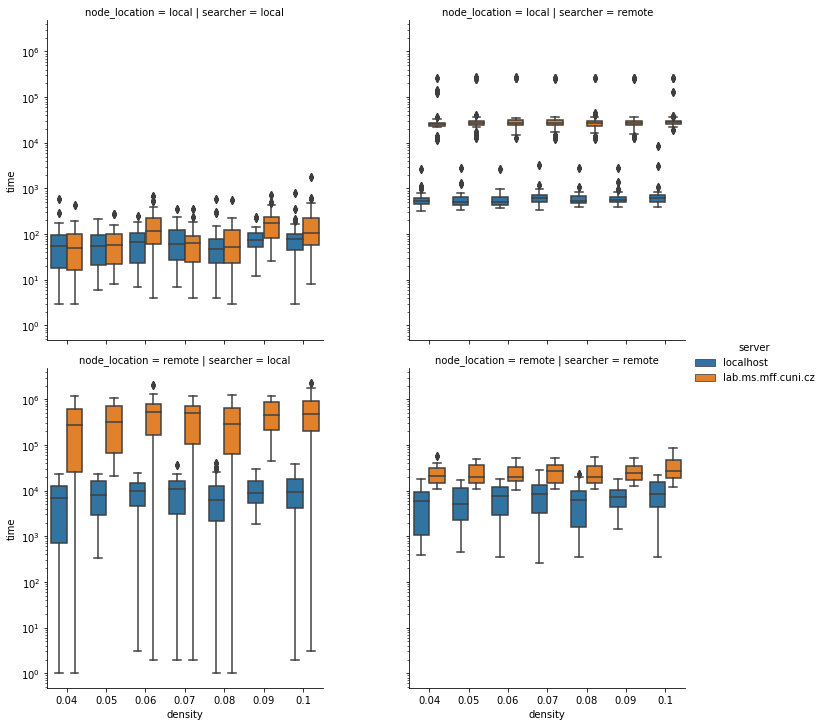

In [9]:
g = sns.catplot(
    data=df[df['transitivity'] == False],
    x='density', y='time', hue='server', row='node_location', col='searcher', kind='box')
g.set_xticklabels(df['density'].unique().round(2))
g.set(yscale='log')

## Task 6 - Pass by value vs. pass by reference a.k.a Transitive solution (part 1 - distance)

When it comes to using transitive solution I have chosen parameter `n` starting at 4 going up to 16 by steps of 4.
First compare different localhost server options.
There is again log scale so that different approaches are comparable.

1. _Local searcher + Local nodes_ (top left)

As previously seen there is a huge variety when there is no path (`distance = -1`).
Then one sees that for `n=4` the solution is faster then the rest and then is suddently spikes for distance 5.
This makes sense since if you load up to 4 levels of neighbors in a single call you find all nodes at such distance.
However, once the distance is higher you have an issue because you have to load another 4 levels of neighbors that costs time compared to having them already loaded at the beginning.

__Choosing `n`__:

Basically if the `n` is equal to the distance the distance between two nodes it is blazing fast compared to `n` begin smaller by one.  
Since this is expected behavior I did not attempt to granularize `n` any further.
It is also not wise to get rid of higher values of `n` since it is highly dependent on the workload and average length of path.
In order to optimize this I would consider typical workload average path length and balance that with cache/network friendlyness of loading next subgraph of `n` levels of depth. 

2. _Remote searcher + Local nodes_ (top right)
3. _Local searcher + Remote nodes_ (bottom left)
4. _Remote searcher + Remote nodes_ (bottom right)

Different location of searcher / nodes follow the same trend.
However it is important to focus on the horizontal levels, polot no. 3 is comparable to solution no. 1 when it comes to load of second batch for `n=4`.
As mentioned previously this one has the whole connected subgraph of asked nodes transfered to the server and thus searching is similar.
Remaining no. 3 and 4 look pretty much same and copy the trend set in measurements done on localhost.

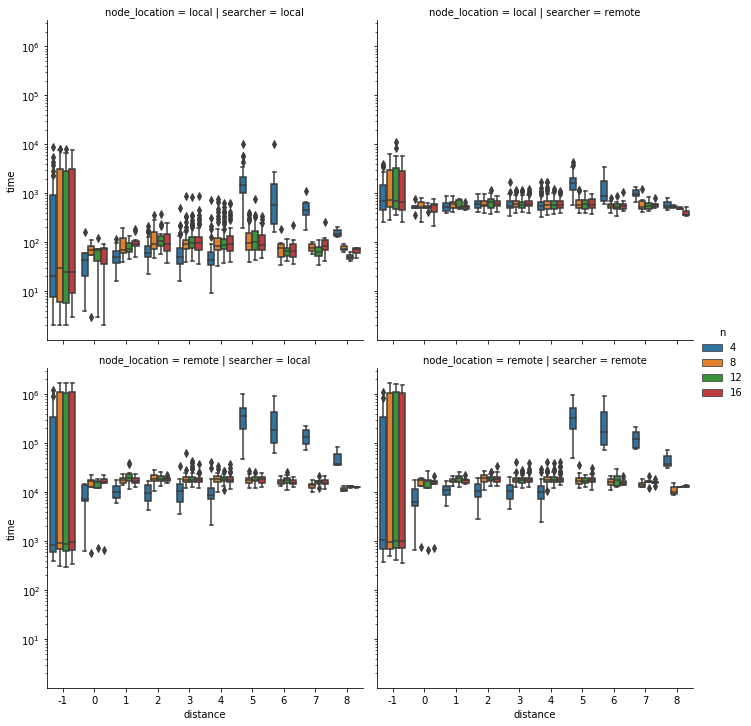

In [10]:
g = sns.catplot(
    data=df[(df['transitivity'] == True) & (df['server'] == 'localhost') & (df['n'].between(4, 16))],
    x='distance', y='time', hue='n', row='node_location', col='searcher', kind='box')
g.set(yscale='log')

## Task 6 - Pass by value vs. pass by reference a.k.a Transitive solution (part 2 - density)

Following graph shows using different values of `n` with different configurations.
We see that for `n=4` time is lower in general except for remote searcher with local nodes because there the graph send as a whole.

Other configurations show this speedup presumably because of the speedups from previous graph and thus are pretty missleading.
The issue is that higher density graphs have more longer paths, but in fact they have way more mid range paths (I assume there will be some normal distribution of path distances) and since for `n=4` paths up to 4 are faster to resolve and there are many such paths it suggesta that `n=4` is better when loogin at graph density.

Again notice orders of magnitude for different configurations that are similar to previous graph.

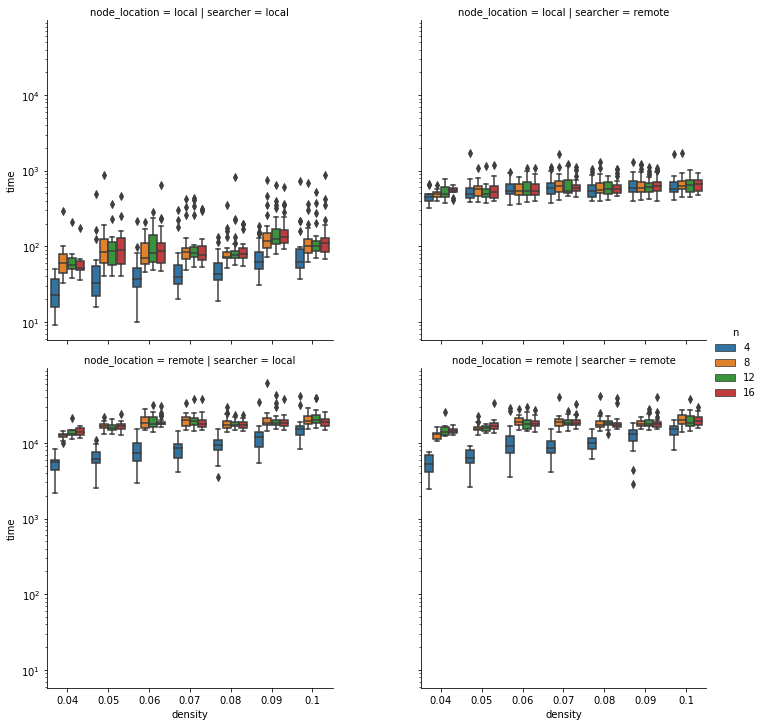

In [11]:
g = sns.catplot(
    data=df[(df['transitivity'] == True) & (df['server'] == 'localhost') & (df['distance'].between(1, 4))],
    x='density', y='time', hue='n', row='node_location', col='searcher', kind='box')
g.set_xticklabels(df['density'].unique().round(2))
g.set(yscale='log')

## Task 6 - Pass by value vs. pass by reference a.k.a Transitive solution (part 3 - transitive vs non-transitive)

To compare transitive and non-transitive solution I have chosen distance on the x axis since it is more indicative w.r.t `n` comapred to density.
Additionaly I have set value for `n=4` since it shows what happens when the distance exceeds `n`.
Graph compares transitive and non-transitive solutions across different configurations first with localhost server.

1. _Local searcher + Local nodes_ (top left)

Same as before transitive solution has some initial cost involved and non transitive reaches it until the transitive makes a jump etc.

2. _Remote searcher + Local nodes_ (top right)

Same as before, whole graph is passed at first call no difference between transitive and non transitive variant.

3. _Local searcher + Remote nodes_ (bottom left)
4. _Remote searcher + Remote nodes_ (bottom right)

Both configurations no. 3 and 4 show common traits in that they need to first fetch transitive nodes and that takes some time (and traffic to server!) compared to solution which progresses level by level.
The server traffic explains the order of magnitude rise in latency.

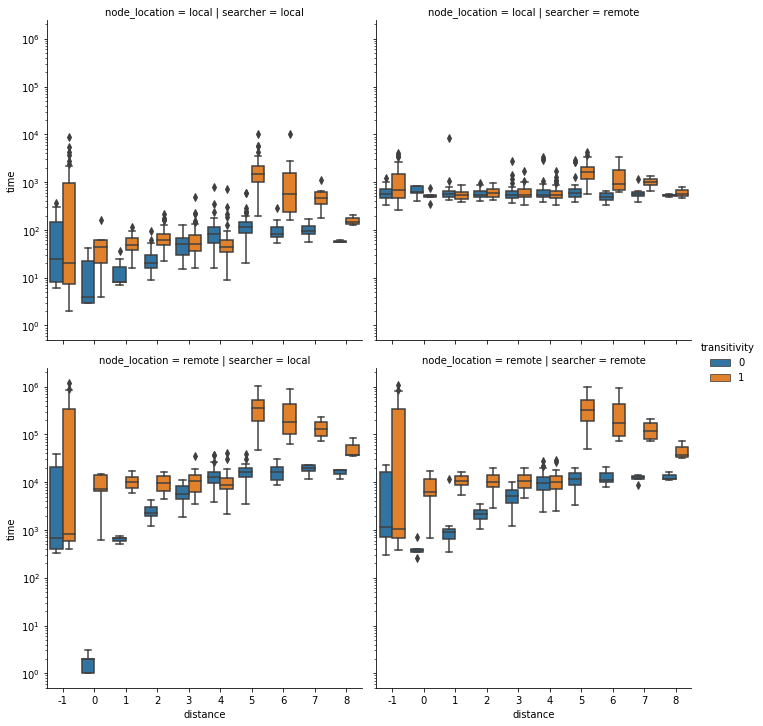

In [14]:
g = sns.catplot(
    data=df[(df['server'] == 'localhost') & (df['n'] == 4 )],
    x='distance', y='time', hue='transitivity', row='node_location', col='searcher', kind='box')
g.set(yscale='log')

## Task 6 - Pass by value vs. pass by reference a.k.a Transitive solution (part 4 - transitive vs non-transitive + network latency)

Setup is similar to previous one but now we put the server in the lab.

1. _Local searcher + Local nodes_ (top left)

Same as before, no network latency.

2. _Remote searcher + Local nodes_ (top right)

Network latency just moved the boxes an order of magnitude up.

3. _Local searcher + Remote nodes_ (bottom left)

As expected the worst solution and the spike to new magnitude is due to combination of transitivity and local searcher + remote nodes characteristics described previously.

4. _Remote searcher + Remote nodes_ (bottom right)

Again similar to previous network latency comparison the non transitive solution does not have traffic with server comparable to solution no. 3.
This still holds for transitive solution, but we see the traditional spike on distance `=n+1`.


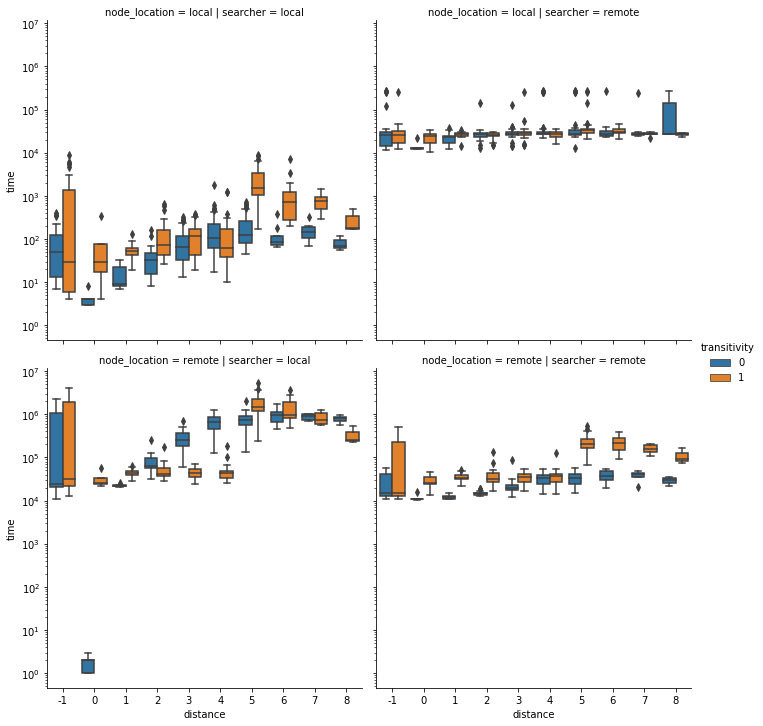

In [15]:
g = sns.catplot(
    data=df[(df['server'] != 'localhost') & (df['n'] == 4)],
    x='distance', y='time', hue='transitivity', row='node_location', col='searcher', kind='box')
g.set(yscale='log')